dia
2015-01-10    2465.58
2015-02-10    3030.82
2015-03-10    2902.68
2015-05-10    2572.89
2015-06-10    2468.40
Name: venda, dtype: float64
2015-01-10 00:00:00
2021-12-08 00:00:00
count     1839.000000
mean      3308.505563
std        860.239278
min        698.280000
25%       2731.410000
50%       3174.660000
75%       3738.805000
max      10933.220000
Name: venda, dtype: float64


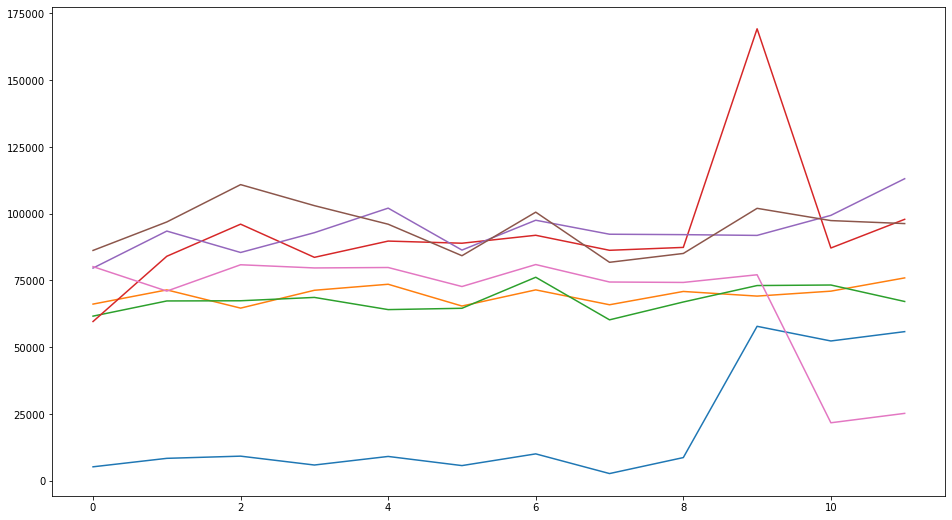

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
 
#from keras.models import Sequential
#from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('vendes10.txt', delimiter=";",decimal=",", parse_dates=[0], header=None,index_col=0, squeeze=True,names=['dia','venda'])

print(df.head())

print(df.index.min())
print(df.index.max())

print(df.describe())

meses =df.resample('M').sum()


meses

plt.plot(meses['2015'].values)
plt.plot(meses['2016'].values)
plt.plot(meses['2017'].values)
plt.plot(meses['2018'].values)
plt.plot(meses['2019'].values)
plt.plot(meses['2020'].values)
plt.plot(meses['2021'].values)

In [2]:
#Extrapolarem les vendes del dia 8e a partir de les vendes dels 7 dies anteriors, organitzem les dades


# Convertim les series a Aprentatge supervisat
PASOS=7

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)

reframed.head()



,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.654654,-0.544201,-0.569240,-0.633684,-0.654103,-0.704223,-0.616897,-0.511049
8,-0.544201,-0.569240,-0.633684,-0.654103,-0.704223,-0.616897,-0.511049,-0.351961
9,-0.569240,-0.633684,-0.654103,-0.704223,-0.616897,-0.511049,-0.351961,-0.483260
10,-0.633684,-0.654103,-0.704223,-0.616897,-0.511049,-0.351961,-0.483260,-0.688055
11,-0.654103,-0.704223,-0.616897,-0.511049,-0.351961,-0.483260,-0.688055,-0.656893


75
300
297
317
300
300
250
2255
(1802, 1, 7) (1802,) (30, 1, 7) (30,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 7)              56        
                                                                 
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
258/258 [==============================] - 3s 5ms/step - loss: 0.1968 - mse: 0.0720 - val_loss: 0.0860 - val_mse: 0.0117
Epoch 2/4
258/258 [==============================] - 1s 3ms/step - loss: 0.1285 - mse: 0.0312 - val_loss: 0.0750 - val_mse:

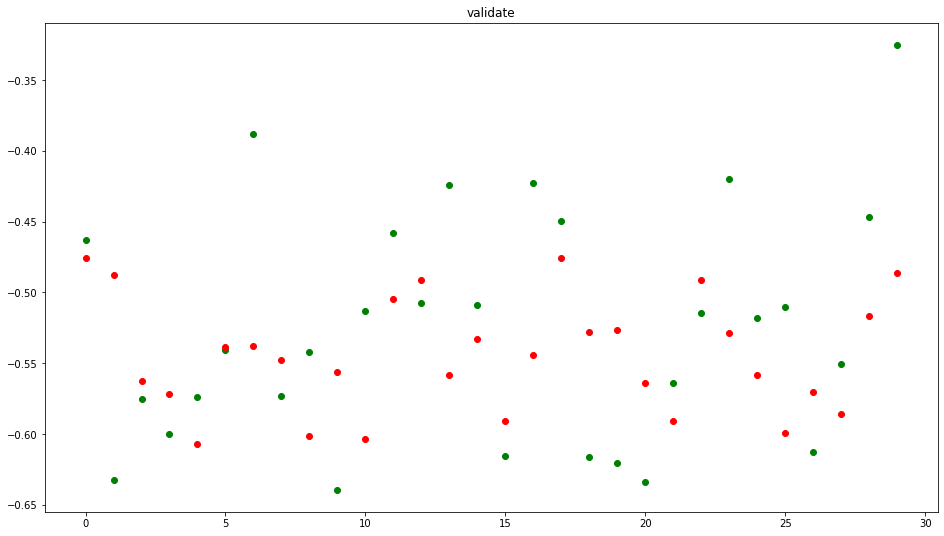

In [3]:
#los primeros 2224 días consecutivos para entrenamiento de la red y los siguientes 30 para su validación. 
#split into train and test sets

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from tensorflow import keras

print(len(df['2015']))
print(len(df['2016']))
print(len(df['2017']))
print(len(df['2018']))
print(len(df['2019']))
print(len(df['2020']))
print(len(df['2021']))
print(len(df))

values = reframed.values
n_train_days = 75+300+297+317+300+300+250 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    
    

    model.summary()
    return model


EPOCHS=4
 
model = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

results=model.predict(x_val)



plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()



In [4]:
ultimosDias = df['2021-10-15':'2021-10-31']
ultimosDias





dia
2021-10-15    3652.97
2021-10-16    3515.91
2021-10-18    2663.49
2021-10-19    2639.82
2021-10-20    2570.01
2021-10-21    2930.46
2021-10-22    3181.90
2021-10-23    3666.95
2021-10-25    3164.06
2021-10-26    3205.56
2021-10-27    2679.34
2021-10-28    2998.64
2021-10-29    3530.56
2021-10-30    4151.39
Name: venda, dtype: float64

    var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
7    0.369639   0.196297  -0.881774  -0.911710  -1.000000  -0.544132   
8    0.196297  -0.881774  -0.911710  -1.000000  -0.544132  -0.226131   
9   -0.881774  -0.911710  -1.000000  -0.544132  -0.226131   0.387320   
10  -0.911710  -1.000000  -0.544132  -0.226131   0.387320  -0.248694   
11  -1.000000  -0.544132  -0.226131   0.387320  -0.248694  -0.196208   
12  -0.544132  -0.226131   0.387320  -0.248694  -0.196208  -0.861728   
13  -0.226131   0.387320  -0.248694  -0.196208  -0.861728  -0.457904   

    var1(t-1)  
7   -0.226131  
8    0.387320  
9   -0.248694  
10  -0.196208  
11  -0.861728  
12  -0.457904  
13   0.214825  
[[[-0.22613144  0.38732004 -0.24869394 -0.196208   -0.86172795
   -0.45790362  0.21482515]]]
[[[ 0.38732004 -0.24869394 -0.196208   -0.86172795 -0.45790362
    0.21482515 -0.00140909]]]
[[[-0.24869394 -0.196208   -0.86172795 -0.45790362  0.21482515
   -0.00140909 -0.18605213]]]
[[[-0.196208   -

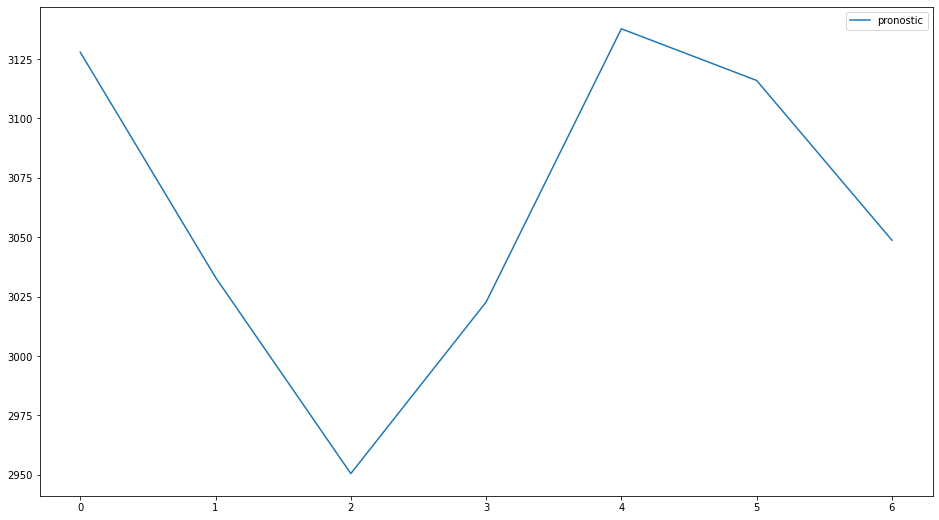

In [5]:

values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
print(reframed.head(7))

values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test



def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test
 
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])
    
    
    
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted


prediccion1SetmanaNovembre = pd.DataFrame(inverted)
prediccion1SetmanaNovembre.columns = ['pronostic']
prediccion1SetmanaNovembre.plot()
prediccion1SetmanaNovembre.to_csv('pronostic.csv')
